In [1]:
# Import some libraries
import numpy as np 
import os
import pandas as pd 
from matplotlib import pyplot as plt 

In [2]:
# Import some libraries from Tesorflow, Scikit learn 
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import LSTM, Dense
# Some libraries from Scikit Learn for  pre-processing data
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


In [3]:
# Read csv data file 
# Declare some variables about the paths and files
data_dir = "D:\\FGW\\GDRIVE\\My BI\\Data"
csv_name = "TESLA_STOCK_2010_2020.csv"
#csv_path = data_dir + "\\" + excel_name
csv_path = os.path.join(data_dir, csv_name)

In [4]:
# We use pandas to read csv file into a dataframe 
stock_df = pd.read_csv(csv_name, parse_dates=True, index_col=0)

In [5]:
stock_df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-06-29,19.000000,25.000000,17.540001,23.889999,23.889999,18766300
2010-06-30,25.790001,30.420000,23.299999,23.830000,23.830000,17187100
2010-07-01,25.000000,25.920000,20.270000,21.959999,21.959999,8218800
2010-07-02,23.000000,23.100000,18.709999,19.200001,19.200001,5139800
2010-07-06,20.000000,20.000000,15.830000,16.110001,16.110001,6866900
...,...,...,...,...,...,...
2020-01-28,568.489990,576.809998,558.080017,566.900024,566.900024,11788500
2020-01-29,575.690002,589.799988,567.429993,580.989990,580.989990,17801500
2020-01-30,632.419983,650.880005,618.000000,640.809998,640.809998,29005700


In [6]:
# Now, there are some steps about pre-processing
# check our data
stock_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2416 entries, 2010-06-29 to 2020-02-03
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2416 non-null   float64
 1   High       2416 non-null   float64
 2   Low        2416 non-null   float64
 3   Close      2416 non-null   float64
 4   Adj Close  2416 non-null   float64
 5   Volume     2416 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 132.1 KB


In [7]:
# cleansing data
# remove some rows that have null cell, remove some rows that are not used
# or to reduce the memory , covert datatype to float32
stock_df.drop(["Adj Close"], axis=1, inplace=True)

<AxesSubplot:xlabel='Date'>

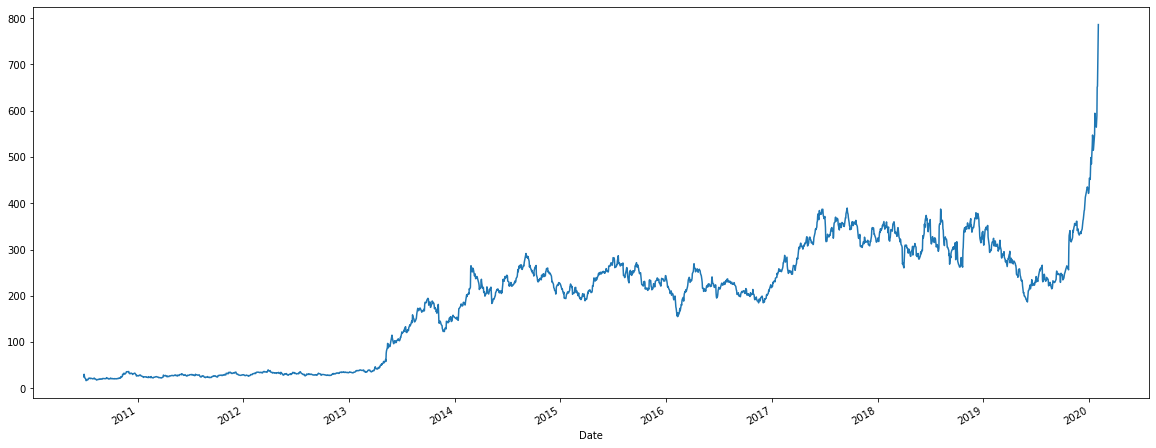

In [8]:
# examine something about our data with plot
stock_df["High"].plot(figsize=(20,8))

<AxesSubplot:xlabel='Date'>

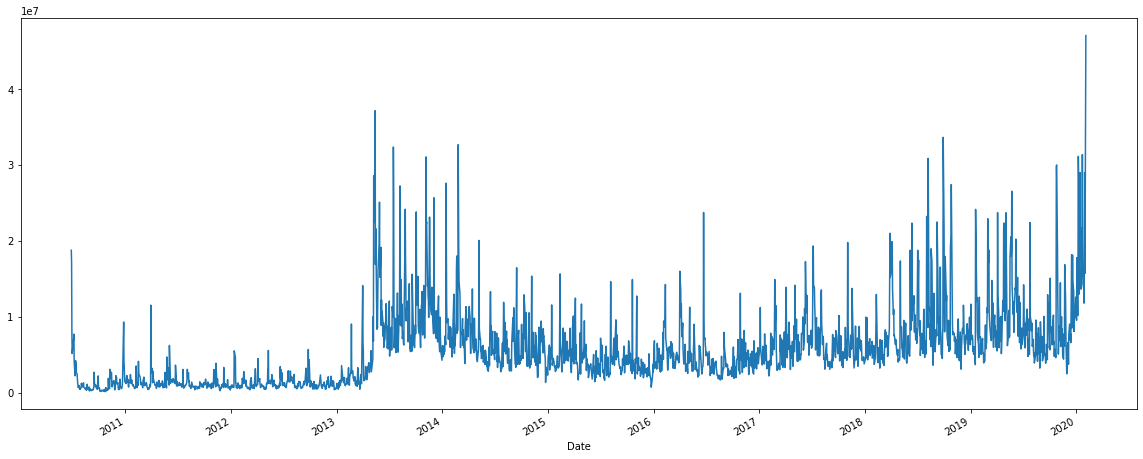

In [9]:
stock_df["Volume"].plot(figsize=(20,8))

In [10]:
# ignore the index data (Date column) for data model
values = stock_df.values

In [11]:
num_cols = len(stock_df.columns)

In [12]:
values.shape

(2416, 5)

In [13]:
# Normalize the data (pre-processing)
# conver datatype as float32 to reduce memory 
values = values.astype('float32')
# Scale the data base on maximum values
# example : 100, 65, 0 --> 1   0.65   0
scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler .fit_transform(values)

In [14]:
scaled

array([[0.00434948, 0.01087705, 0.00388739, 0.01058623, 0.39721385],
       [0.01467569, 0.0179205 , 0.01263401, 0.01050772, 0.36357558],
       [0.01347426, 0.01207262, 0.00803292, 0.00806071, 0.17254321],
       ...,
       [0.93723667, 0.82422584, 0.9156922 , 0.81786174, 0.6153217 ],
       [0.9487643 , 0.8269808 , 0.93774104, 0.8306333 , 0.3323102 ],
       [1.        , 1.        , 1.        , 0.99999994, 1.        ]],
      dtype=float32)

In [15]:
col_names = [name for name in stock_df.columns]

In [16]:
col_names

['Open', 'High', 'Low', 'Close', 'Volume']

In [17]:
# data generation for Machine learning model 
def dataset_gen(data, col_names, num_steps_in=1, num_steps_out=1):
    '''
    num_step_in: number steps of history (in the past) data 
    num_step_out: number steps of future (in the past) data
    '''
    df = pd.DataFrame(data)
    columns = []
    names = []
    # Create the historical data 
    for i in range(num_steps_in, 0, -1):
        columns.append(df.shift(i))
        names += ['%s(t-%d)' %(n, i) for n in col_names]
                   
    # create the future data                
    for i in range(0, num_steps_out):
        columns.append(df.shift(-i))
        if i == 0:
            names += [('%s(t)' %n) for n in col_names]
        else: 
            names += [('%s(t +%d)' %n) for n in col_names]
    dataset = pd.concat(columns, axis=1)
    #print(len(dataset.columns))
    #print(len(names))
    dataset.columns = names
    return dataset
        

In [18]:
num_steps_in = 6
num_steps_out = 1
dataset = dataset_gen(scaled, col_names, num_steps_in, num_steps_out)

In [19]:
dataset.dropna(inplace=True)

In [20]:
dataset[:10]

,Open(t-6),High(t-6),Low(t-6),Close(t-6),Volume(t-6),Open(t-5),High(t-5),Low(t-5),Close(t-5),Volume(t-5),...,Open(t-1),High(t-1),Low(t-1),Close(t-1),Volume(t-1),Open(t),High(t),Low(t),Close(t),Volume(t)
6,0.004349,0.010877,0.003887,0.010586,0.397214,0.014676,0.017920,0.012634,0.010508,0.363576,...,0.000395,0.000000,0.000000,0.000000,0.144914,0.000000,0.001157,0.000896,0.002172,0.161735
7,0.014676,0.017920,0.012634,0.010508,0.363576,0.013474,0.012073,0.008033,0.008061,0.172543,...,0.000000,0.001157,0.000896,0.002172,0.161735,0.002190,0.001650,0.002384,0.002094,0.083757
8,0.013474,0.012073,0.008033,0.008061,0.172543,0.010433,0.008408,0.005664,0.004449,0.106958,...,0.002190,0.001650,0.002384,0.002094,0.083757,0.002753,0.001871,0.003067,0.001636,0.044391
9,0.010433,0.008408,0.005664,0.004449,0.106958,0.005870,0.004379,0.001291,0.000406,0.143747,...,0.002753,0.001871,0.003067,0.001636,0.044391,0.001901,0.002612,0.002916,0.003062,0.054564
10,0.005870,0.004379,0.001291,0.000406,0.143747,0.000395,0.000000,0.000000,0.000000,0.144914,...,0.001901,0.002612,0.002916,0.003062,0.054564,0.002737,0.004574,0.004221,0.005287,0.086837
11,0.000395,0.000000,0.000000,0.000000,0.144914,0.000000,0.001157,0.000896,0.002172,0.161735,...,0.002737,0.004574,0.004221,0.005287,0.086837,0.005779,0.006329,0.006104,0.005352,0.077137
12,0.000000,0.001157,0.000896,0.002172,0.161735,0.002190,0.001650,0.002384,0.002094,0.083757,...,0.005779,0.006329,0.006104,0.005352,0.077137,0.006935,0.006069,0.007699,0.006333,0.053312
13,0.002190,0.001650,0.002384,0.002094,0.083757,0.002753,0.001871,0.003067,0.001636,0.044391,...,0.006935,0.006069,0.007699,0.006333,0.053312,0.007954,0.007303,0.009020,0.007995,0.050440
14,0.002753,0.001871,0.003067,0.001636,0.044391,0.001901,0.002612,0.002916,0.003062,0.054564,...,0.007954,0.007303,0.009020,0.007995,0.050440,0.008684,0.006784,0.007699,0.005889,0.036356
15,0.001901,0.002612,0.002916,0.003062,0.054564,0.002737,0.004574,0.004221,0.005287,0.086837,...,0.008684,0.006784,0.007699,0.005889,0.036356,0.006874,0.005549,0.006864,0.005784,0.024155


In [21]:
values = dataset.values

In [22]:
# we have split out data into train:test data, scale 80%:20%
train_size = int(len(values)*0.8)
test_size = len(values) - train_size

In [23]:
train = values[0:train_size]
test = values[train_size: len(values)]

In [24]:
print(len(train), len(test))

1928 482


In [25]:
num_cols = len(col_names)
num_col_input = num_steps_in*num_cols
num_col_target = num_steps_out*num_cols

In [26]:
# We try to predict the Open values in the future
target_idx = [dataset.columns.to_list().index(col) for col in dataset.columns[num_col_input:] if 'Open' in col]

In [27]:
target_idx

[30]

In [28]:
train.shape

(1928, 35)

In [29]:
train_X = train[:, 0: num_col_input]
train_y = train[:, target_idx]

In [30]:
test_X, test_y = test[:, 0: num_col_input], test[:, target_idx]

In [31]:
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(1928, 30) (1928, 1) (482, 30) (482, 1)


In [32]:
train_X[0]

array([4.34947945e-03, 1.08770542e-02, 3.88738886e-03, 1.05862319e-02,
       3.97213846e-01, 1.46756917e-02, 1.79204978e-02, 1.26340073e-02,
       1.05077196e-02, 3.63575578e-01, 1.34742595e-02, 1.20726191e-02,
       8.03292170e-03, 8.06071423e-03, 1.72543213e-01, 1.04326680e-02,
       8.40795040e-03, 5.66404313e-03, 4.44909744e-03, 1.06957912e-01,
       5.87027520e-03, 4.37941216e-03, 1.29073299e-03, 4.05652449e-04,
       1.43746600e-01, 3.95406038e-04, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.44913882e-01], dtype=float32)

In [33]:
n_features = num_cols

In [34]:
train_X = train_X.reshape(train_X.shape[0], num_steps_in, num_cols)

In [35]:
train_X.shape

(1928, 6, 5)

In [36]:
test_X = test_X.reshape(test_X.shape[0], num_steps_in, num_cols)

In [37]:
test_X.shape

(482, 6, 5)

In [38]:
train_y.shape, train_X.shape

((1928, 1), (1928, 6, 5))

In [39]:
# Create the LSTM model 
model = Sequential()
model.add(LSTM(150, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(train_y.shape[1]))

In [40]:
(train_X.shape[1], train_X.shape[2]) == train_X[0].shape

True

In [41]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 150)               93600     
_________________________________________________________________
dense (Dense)                (None, 1)                 151       
Total params: 93,751
Trainable params: 93,751
Non-trainable params: 0
_________________________________________________________________


In [42]:
# Select loss function and an optimizer 
model.compile(loss="mean_squared_error", optimizer="adam")

In [43]:
# train the model 
t = model.fit(train_X, train_y, epochs=50, batch_size=32,
              validation_data=(test_X, test_y),
              verbose=1, 
              shuffle=False
             )

Epoch 1/50
61/61 [==============================] - 3s 18ms/step - loss: 5.9255e-04 - val_loss: 0.0012
Epoch 2/50
61/61 [==============================] - 1s 9ms/step - loss: 5.8454e-04 - val_loss: 6.2532e-04
Epoch 3/50
61/61 [==============================] - 1s 10ms/step - loss: 2.7157e-04 - val_loss: 5.2739e-04
Epoch 4/50
61/61 [==============================] - 1s 9ms/step - loss: 1.4928e-04 - val_loss: 4.6899e-04
Epoch 5/50
61/61 [==============================] - 1s 9ms/step - loss: 1.2489e-04 - val_loss: 4.4512e-04
Epoch 6/50
61/61 [==============================] - 1s 9ms/step - loss: 1.1371e-04 - val_loss: 4.3521e-04
Epoch 7/50
61/61 [==============================] - 1s 10ms/step - loss: 1.0739e-04 - val_loss: 4.2747e-04
Epoch 8/50
61/61 [==============================] - 1s 9ms/step - loss: 1.0390e-04 - val_loss: 4.1985e-04
Epoch 9/50
61/61 [==============================] - 1s 9ms/step - loss: 1.0058e-04 - val_loss: 4.1097e-04
Epoch 10/50
61/61 [============================

In [44]:
train_y

array([[0.        ],
       [0.00218995],
       [0.00275264],
       ...,
       [0.5001445 ],
       [0.47272453],
       [0.48095202]], dtype=float32)